In this part we wanted to explore whether a good beer is a good beer everywhere? In other words is a beer that is well rated preceived as good everywhere or rather does where you live and culture affect how you rate a beer. Do your country, entourage, habits make you like a beer more or less?

Culture can play a role in how an individual perceives and rates a beer, as cultural influences can shape an individual's taste preferences and expectations for different types of beer. For example, a person from a culture with a strong tradition of brewing and consuming hoppy beers may have different preferences and expectations for a hoppy beer compared to someone from a culture with a different tradition.

It's important to note that these cultural influences are just one factor among many that can affect an individual's rating of a beer but we thought this was one of the most interesting factors affecting how you could rate a beer given the data we have.

In [141]:
#reading data
import gzip 

#manipulating data 
import pandas as pd
import numpy as np
import datetime

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
from math import pi

import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo

import random


#clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

#creating a map 
import folium 

#pca
from pca import pca

#numpy normalize
from numpy.linalg import norm

In [3]:
PATH= '../'

We start by loading both dataframes from BeerAdvocate and RateBeer:

In [3]:
df_BA_reviews = pd.read_csv('../DataframeStorage/df_BA_reviews.csv')
df_BA_reviews['date'] = pd.to_datetime(df_BA_reviews['date'], format="%Y-%m-%d %H:%M:%S")

In [4]:
df_RB_reviews = pd.read_csv('../DataframeStorage/df_RB_reviews.csv')
df_RB_reviews['date'] = pd.to_datetime(df_RB_reviews['date'], format="%Y-%m-%d %H:%M:%S")

Since here we work on locations, we define two new dataframes where we remove all the unknown locations:

In [5]:
df_BA_reviews_location = df_BA_reviews[(df_BA_reviews.user_location!='Unknown') & (df_BA_reviews.brewery_location!='Unknown')]
df_RB_reviews_location = df_RB_reviews[(df_RB_reviews.user_location!='Unknown') & (df_RB_reviews.brewery_location!='Unknown')]

We'll concatenate both dataframes from BeerAdvocate and RateBeer to put all the data together since they contain the same features:

In [6]:
df_reviews_locations = pd.concat([df_BA_reviews_location, df_RB_reviews_location], axis=0)

In [4]:
df_reviews_locations = pd.read_csv('../DataframeStorage/df_reviews_locations.csv')

/opt/anaconda3/envs/ada/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3135: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
df_reviews_locations.head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,brewery_location,brewery_merged_location,user_location,user_merged_location
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",Gabon,Gabon,"United States, Washington",United States
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...,Northern Ireland,Northern Ireland,"United States, New York",United States


We define a df_coordinates dataframe with the longitudes and latitudes of the world countries and US states in order to be able to plot maps. The data for the coordinates is taken from [here](https://www.mapsofworld.com/world-maps/world-map-with-latitude-and-longitude.html) and [here](https://www.mapsofworld.com/lat_long/usa-lat-long.html).

In [79]:
df_country_coordinates = pd.read_csv('../country2.csv')
df_country_coordinates = df_country_coordinates[['name','Latitude', 'Longitude']]

df_US_states_coordinates= pd.read_csv('../US_states.csv', index_col= 'name')
df_US_states_coordinates = df_US_states_coordinates.reset_index(level=0)
df_US_states_coordinates['name'] = df_US_states_coordinates['name'].apply(lambda x: 'United States, ' + x)

frames = [df_country_coordinates, df_US_states_coordinates]
df_coordinates = pd.concat(frames)
df_coordinates = df_coordinates.set_index('name')

## Do people tend to rate better their local beers?

Let's next take a look at the proportions of the location of the reviewers for very well rated beers (defined here as a rating>4), do they tend to be local to the country/area or not necessarily?

As a reminder the 'merged' location columns are the same as their unmerged counterparts but with the states of the United States grouped into one 'United States' category. This was done for when comparison at the country scale is necessary.

We start by checking where most of the users who rate beers more than 4 out of 5 come from:

In [6]:
good_beers_user_location_counts = pd.DataFrame(df_reviews_locations.loc[df_reviews_locations['rating']>4]['user_merged_location'].value_counts())
good_beers_user_location_counts = good_beers_user_location_counts.rename(columns={"user_merged_location": "Number of users"})

In [15]:
good_beers_user_location_counts.head(10)

,Number of users
United States,1411060
Canada,86009
England,29255
Denmark,23638
Sweden,23443
Netherlands,20539
Poland,18450
Belgium,16630
Australia,15316
Germany,11852


We take the user location countries which have at least 1000 reviews as a count, and we plot the relative proportions of well reviewed (rating>4) beers which are brewed in the same country as the user location ('Local brewery') and the ones that aren't : 

In [9]:
good_beers_user_location_counts_1000 = good_beers_user_location_counts.loc[good_beers_user_location_counts['Number of users']>1000]

In [18]:
df_country_barplot = pd.DataFrame (columns = ['Local brewery','Out of country/state brewery'],
                                  index = good_beers_user_location_counts_1000.index)

In [21]:
for country in good_beers_user_location_counts_1000.index:
    location_users_data = df_reviews_locations[df_reviews_locations['user_merged_location'] == country]
    dummy_location = (location_users_data['brewery_merged_location']== country).astype(int)
    proportions = dummy_location.value_counts(normalize= True)
    df_country_barplot.loc[country]['Local brewery']=proportions[1]
    df_country_barplot.loc[country]['Out of country/state brewery']=proportions[0]

In [22]:
df_country_barplot.reset_index(inplace=True)
df_country_barplot = df_country_barplot.rename(columns = {'index':'Countries'})

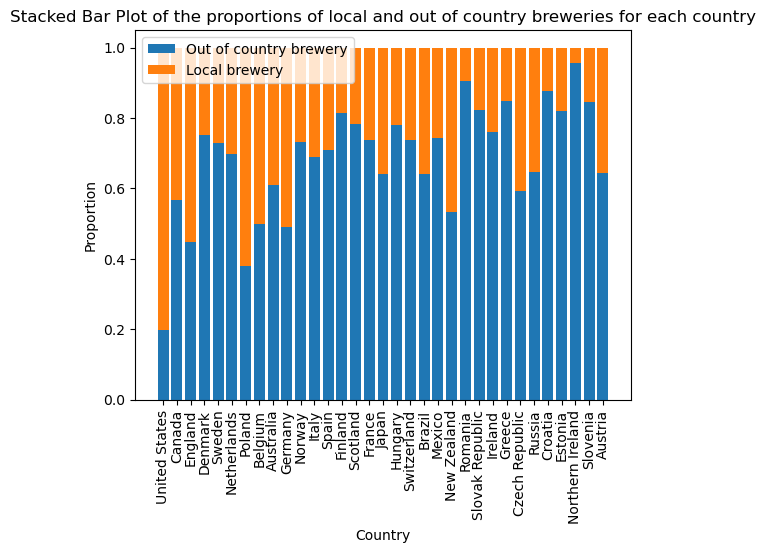

In [37]:
# Set the data for the plot
countries = df_country_barplot['Countries']
proportion1 = df_country_barplot['Out of country/state brewery']
proportion2 = df_country_barplot['Local brewery']

# Create the bar plot
plt.bar(countries, proportion1, label='Out of country brewery')
plt.bar(countries, proportion2, bottom=proportion1, label='Local brewery')

# Add labels and title
plt.xlabel('Country')
plt.ylabel('Proportion')
plt.title('Stacked Bar Plot of the proportions of local and out of country breweries for each country')

# Add a legend
plt.legend()
plt.xticks(rotation=90)
# Show the plot
plt.show()

So at first glance, we observe that for most of these countries the beers rated higher than 4 are brewed out of their own country except for the United States, Belgium, Germany and England.

For the United States, the above plot shows all the states combined as we grouped them in the 'user_merged_location' column, the data is the grouped States data, so it is thus interesting to do the same analysis on the individual US states. Also since more than 50% of the users have as a location the United States:

In [214]:
len(df_reviews_locations.loc[df_reviews_locations['user_merged_location']=='United States'])/len(df_reviews_locations)

0.5821138938257506

58% of the data lies in the United States. So we do what we did above but for individual States rather than countries:

We proceed similarly for the following plot:

In [26]:
#We start by observing where the users who rate beers more than 4 out of 5 come from:
good_beers_user_location_US = df_reviews_locations.loc[df_reviews_locations['user_location'].str.startswith('United States')]
good_beers_user_location_US_counts = pd.DataFrame(good_beers_user_location_US.loc[good_beers_user_location_US['rating']>4]['user_location'].value_counts())
good_beers_user_location_US_counts = good_beers_user_location_US_counts.rename(columns={"user_merged_location": "Number of users"})

In [27]:
df_states_barplot = pd.DataFrame (columns = ['Local brewery','Out of country/state brewery'],
                                  index = good_beers_user_location_US_counts.index)

In [28]:
for state in good_beers_user_location_US_counts.index:
    location_users_data = df_reviews_locations[df_reviews_locations['user_location'] == state]
    dummy_location = (location_users_data['brewery_location']== state).astype(int)
    proportions = dummy_location.value_counts(normalize= True)
    df_states_barplot.loc[state]['Local brewery']=proportions[1]
    df_states_barplot.loc[state]['Out of country/state brewery']=proportions[0]

df_states_barplot.reset_index(inplace=True)

In [29]:
df_states_barplot = df_states_barplot.rename(columns = {'index':'States'})

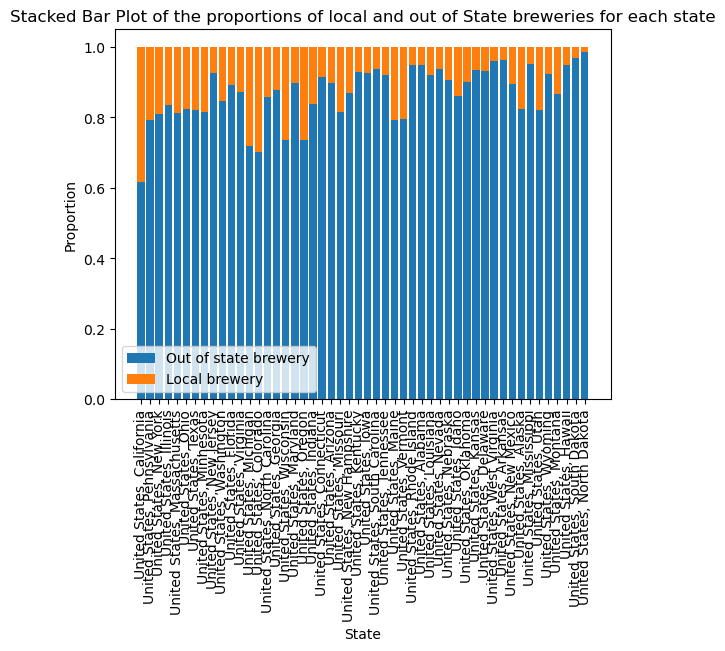

In [39]:
# Set the data for the plot
states = df_states_barplot['States']
proportion1 = df_states_barplot['Out of country/state brewery']
proportion2 = df_states_barplot['Local brewery']

# Create the bar plot
plt.bar(states, proportion1, label='Out of state brewery')
plt.bar(states, proportion2, bottom=proportion1, label='Local brewery')

# Add labels and title
plt.xlabel('State')
plt.ylabel('Proportion')
plt.title('Stacked Bar Plot of the proportions of local and out of State breweries for each state')

# Add a legend
plt.legend()
plt.xticks(rotation=90)
# Show the plot
plt.show()

At first glance it seems that even state by state, most people's top rated beers don't come from their own states.

But thinking further, maybe the physical location of the user and the brewery isn't enough to define this cultural/location bias. In fact, maybe beers brewed in California and Oregon have similar styles of brewing, making both populations consume beers brewed in either location regardless of whether it's local or not. Thus we need to define a more precise way to measure this cultural bias.

For every beer, we have access to its style with the feature 'style'. The beer's style is quite revealing of beer cultures.
Different beer styles can provide insight into the cultural and historical context in which they were developed. Each beer style has its own unique characteristics and flavor profile that is influenced by the ingredients, techniques, and traditions of the region in which it is produced. Different beer styles can offer a unique window into the traditions and practices of a particular region. This in turn can influence one's beer preferences more than the physical location of the brewery.

So we decide to create a vector for each country that contains a 'style stamp'. Essentially, each beer style will have a weight associated to it depending how well that particular style is rated in a country/region. Then the idea is to see whether some countries/states cluster together based on how close their preferences are.

In the following section we create a dataframe which will contain a vector per country accounting for how much users from a certain country rate (higher than 4) each style of beer. This defines a sort of 'cultural stamp' vector per country which is probably much better at describing what each user likes compared to just investigating the location of the breweries compared of the location of the users.

## Defining style vectors for each country

### Reviews with rating higher than 4

We start by filtering all the reviews by the ones that have received a rating higher than 4:

In [40]:
df_reviews_all_good_beers = df_reviews_locations.loc[df_reviews_locations['rating']>4]

Next we define df_beer_style_score which contains a vector per country containing the normalized percentages of the number of reviews that review a certain style of beer (for ratings higher than 4):

In [41]:
countries = df_reviews_all_good_beers['user_location'].unique() #a vector containing the list of unique countries
df_beer_style_score_good = pd.DataFrame(index=df_reviews_all_good_beers['style'].unique()) #define a DataFrame where the indices are all the beer styles

for country in countries:
    df_country = pd.DataFrame(df_reviews_all_good_beers.loc[df_reviews_all_good_beers['user_location']==country]['style'].value_counts(normalize= True).reindex(df_reviews_all_good_beers['style'].unique(), fill_value=0)) #puts 0's for the values where the count was 0
    df_country = df_country.rename(columns={ "style": country})
    df_beer_style_score_good = df_beer_style_score_good.join(df_country)

df_beer_style_score_good = df_beer_style_score_good.T

In [42]:
df_beer_style_score_good.head()

,English Pale Ale,English Bitter,Irish Red Ale,American Stout,Munich Helles Lager,English Brown Ale,English India Pale Ale (IPA),English Porter,American IPA,American Pale Ale (APA),...,Perry,Saké - Infused,Saké - Koshu,Saké - Daiginjo,Saké - Taru,Saké - Ginjo,Sahti/Gotlandsdricke/Koduõlu,Saké - Genshu,Saké - Junmai,Lambic Style - Faro
"United States, Georgia",0.002582,0.000880,0.001702,0.009930,0.001390,0.004965,0.002582,0.004596,0.074448,0.018697,...,0.000028,0.0,0.0,0.0,0.000028,0.0,0.000000,0.0,0.0,0.000113
"United States, New Jersey",0.004177,0.001227,0.001148,0.009541,0.001940,0.003801,0.003642,0.004177,0.081793,0.027079,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000178,0.0,0.0,0.000119
"United States, Alaska",0.004140,0.005175,0.000776,0.011643,0.002587,0.003622,0.004398,0.005951,0.056921,0.021992,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
Northern Ireland,0.030769,0.021862,0.003239,0.004049,0.000810,0.007287,0.021862,0.017814,0.038057,0.013765,...,0.000810,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
"United States, North Carolina",0.003335,0.001482,0.001630,0.014797,0.002050,0.004224,0.004150,0.005039,0.089744,0.026259,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000099,0.0,0.0,0.000099


Next we want to perform clustering over these 'style' vectors to see if some regions cluster together, indicating a preference for a certain brewing style regionally.

There are 178 different beer styles, so 178 different features. The data is extremely high dimensionsal so we do feature selection using PCA to identify which features capture 95% of the explained variance of the data:

In [43]:
# Initialize
model = pca()
# Fit transform
out = model.fit_transform(df_beer_style_score_good)

# Print the top features. The results show that f1 is best, followed by f2 etc
print(out['topfeat'])

#     PC      feature
# 0  PC1      f1
# 1  PC2      f2
# 2  PC3      f3
# 3  PC4      f4
# 4  PC5      f5
# 5  PC6      f6
# 6  PC7      f7
# 7  PC8      f8
# 8  PC9      f9

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [178] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [42] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [178] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[42]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
       PC                       feature   loading  type
0     PC1                    Pale Lager  0.980292  best
1     PC2                Imperial Stout  0.696139  best
2     PC3                   Malt Liquor  0.918376  best
3     PC4                     Brown Ale  0.964629  best
4     PC5            Belgian Strong Ale  0.532003  best
..    ...                           ...       ...   ...
177  

So we select the 42 features corresponding to the those top features:

In [44]:
top_features = out['topfeat'].head(42).feature
df_beer_style_score_good = df_beer_style_score_good[top_features]

Next we perform K-means clutering. In order to select the optimal number of clusters, we run k-means over a range of values of K (number of clusters) and for each value we calculate the average distances to the centroid across all data points, we plot the result to find the point where the average distance from the centroid falls suddenly (the elbow of the curve):

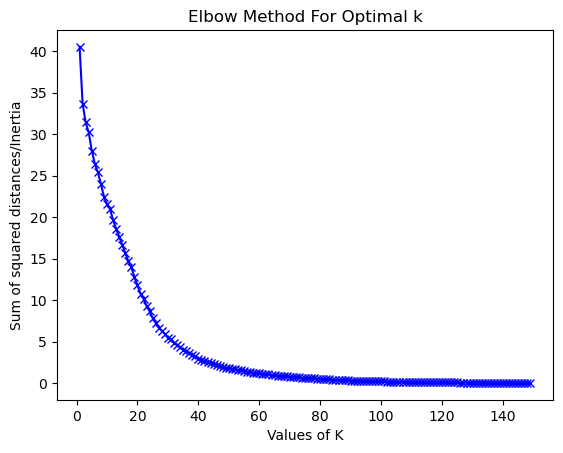

In [27]:
Sum_of_squared_distances = []
K = range(1,150)

for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(df_beer_style_score_good)
 Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

It looks like the elbow is around the value of K=35

In [86]:
#running k-means with the found optimal k
kmeans = KMeans(35)
kmeans.fit(df_beer_style_score_good)
clusters=kmeans.fit_predict(df_beer_style_score_good)

In [87]:
clusters_data=df_beer_style_score_good.copy()
#assigning the clusters to the data 
clusters_data['Cluster']=clusters

Next we want to plot the clusters on a map, so we use data with the longitutde and latitudes of each country and each state in the United States: 

In [47]:
plotting_data = clusters_data.join(df_coordinates)
plotting_data = plotting_data.dropna(axis=0)

In [48]:
#So we have the assigned Cluster, Longitude and Latitude to each data point:
plotting_data[['Cluster', 'Longitude', 'Latitude']].head()

,Cluster,Longitude,Latitude
"United States, Georgia",3,-82.907123,32.157435
"United States, New Jersey",3,-74.405661,40.058324
"United States, Alaska",3,-154.493062,63.588753
Northern Ireland,3,6.492300,54.7877
"United States, North Carolina",3,-79.019300,35.759573


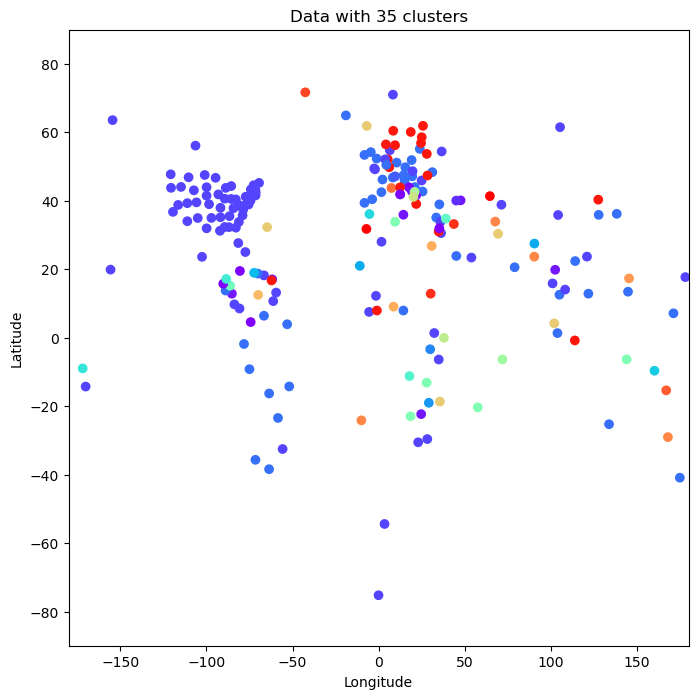

In [49]:
#Visualizing the clusters on the longitude and latitude
plt.figure(figsize=(8,8))
plt.scatter(plotting_data['Longitude'], plotting_data['Latitude'], c=plotting_data['Cluster'],cmap='rainbow')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Data with 35 clusters')

In [50]:
map_clusters = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)

# set color scheme for the clusters
x = np.arange(40)
ys = [i + x + (i*x)**2 for i in range(35)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]



# add markers to map
markers_colors = []
for lat, lng, cluster, country in zip(plotting_data['Latitude'],
                                        plotting_data['Longitude'],  
                                        plotting_data['Cluster'],
                                        plotting_data.index):

    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        tooltip = str(country)+ ','+ ' cluster ' + str(cluster),
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

Finally, let's visualize the map with  Plotly:

### Assigning different weights according to the rating

Next we try out a different way to create the vectors of 'style'. Below, we use all ratings but we assign different weights to the count of reviews depending on the rating: <br>
- Reviews that have a rating lower than 2 get a weight of 1
- Reviews that have a rating higher than 2 and lower than 3 get a weight of 2
- Reviews that have a rating higher than 3 and lower than 4 get a weight of 3
- Reviews that have a rating higher than 4 get a weight of 4

In [84]:
#define dataframes for each category of rating
value_counts_1 = df_reviews_locations.loc[df_reviews_locations['rating']<2]
value_counts_2 = df_reviews_locations.loc[(df_reviews_locations['rating']<3) & (df_reviews_locations['rating']>2)]
value_counts_3 = df_reviews_locations.loc[(df_reviews_locations['rating']<4) & (df_reviews_locations['rating']>3)]
value_counts_4 = df_reviews_locations.loc[df_reviews_locations['rating']>4]

In [85]:
beer_style_score = pd.DataFrame(index=df_reviews_locations['style'].unique()) 

In [73]:
#create a list of the countries contained in the dataframe
countries = df_reviews_locations['user_location'].unique() 
#define a DataFrame where the indices are all the beer styles
beer_style_score = pd.DataFrame(index=df_reviews_locations['style'].unique()) 

#below we create the beer_style_score dataframe which contains 
for country in countries:
    count_1 = value_counts_1.loc[value_counts_1['user_location']==country]['style'].value_counts().reindex(df_reviews_locations['style'].unique(), fill_value=0) #puts 0's for the values where the count was 0
    count_2 = value_counts_2.loc[value_counts_2['user_location']==country]['style'].value_counts().reindex(df_reviews_locations['style'].unique(), fill_value=0)
    count_3 = value_counts_3.loc[value_counts_3['user_location']==country]['style'].value_counts().reindex(df_reviews_locations['style'].unique(), fill_value=0)
    count_4 = value_counts_4.loc[value_counts_4['user_location']==country]['style'].value_counts().reindex(df_reviews_locations['style'].unique(), fill_value=0)
    df_country_weighted_count = pd.DataFrame(normalize([count_1*1 + count_2*2 + count_3*3 + count_4*4])).T
    df_country_weighted_count = df_country_weighted_count.set_index(count_1.index) 
    df_country_weighted_count = df_country_weighted_count.rename(columns={ 0: country})
    beer_style_score = beer_style_score.join(df_country_weighted_count)

df_beer_style_score = beer_style_score.T

We save it into a dataframe because we will use it in the following sections:

In [70]:
df_beer_style_score.to_csv(PATH+'/DataframeStorage/style_scores.csv')

In [101]:
#loading that dataframe
df_beer_style_score = pd.read_csv(PATH+'/DataframeStorage/style_scores.csv' , index_col='Unnamed: 0')

In [102]:
df_beer_style_score.head(1)

,Pale Lager,American IPA,India Pale Ale (IPA),Imperial Stout,Golden Ale/Blond Ale,Euro Pale Lager,Amber Lager/Vienna,Pilsener,Malt Liquor,Porter,...,Baltic Porter,Amber Ale,Fruit Beer,Spice/Herb/Vegetable,Barley Wine,English Porter,Zwickel/Keller/Landbier,Cluster,Latitude,Longitude
"United States, Washington",0.084424,0.357018,0.462548,0.25401,0.055105,0.012461,0.032079,0.061046,0.010246,0.147742,...,0.050027,0.116571,0.075734,0.108029,0.14113,0.014529,0.010019,4,47.751074,-120.740139


In [103]:
df_beer_style_score.drop(["Cluster", "Latitude",'Longitude'], axis = 1, inplace=True)

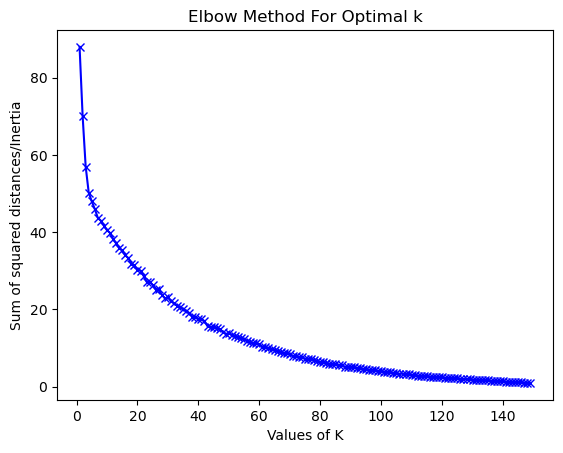

In [106]:
Sum_of_squared_distances = []

K = range(1,150)

for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(df_beer_style_score)
 Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [118]:
kmeans = KMeans(25)
kmeans.fit(df_beer_style_score)
clusters=kmeans.fit_predict(df_beer_style_score)

In [119]:
clusters_data = df_beer_style_score.copy()
clusters_data['Cluster']=clusters

plotting_data = clusters_data.join(df_coordinates)
plotting_data = plotting_data.dropna(axis=0)

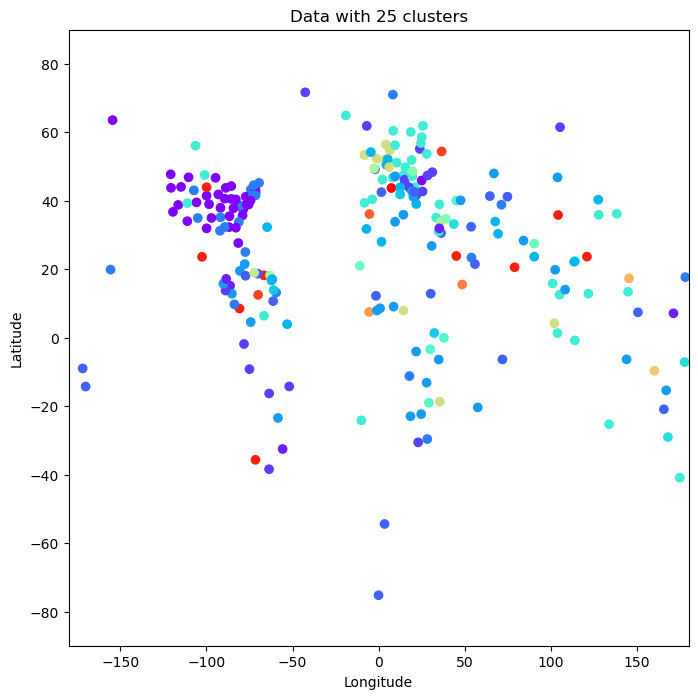

In [120]:
plt.figure(figsize=(8,8))
plt.scatter(plotting_data['Longitude'],plotting_data["Latitude"],c=plotting_data['Cluster'],cmap='rainbow')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Data with 25 clusters") 
plt.xlim(-180,180)
plt.ylim(-90, 90)
plt.show()

In [121]:
map_clusters = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)

# set color scheme for the clusters
x = np.arange(25)
ys = [i + x + (i*x)**2 for i in range(25)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]



# add markers to map
markers_colors = []
for lat, lng, cluster, country in zip(plotting_data['Latitude'],
                                        plotting_data['Longitude'],  
                                        plotting_data['Cluster'],
                                        plotting_data.index):

    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        tooltip = str(country)+ ','+ ' cluster ' + str(cluster),
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

We definitely see major region clusters on this map, the largest 10 clusters are represented below:

In [123]:
print('The largest clusters of countries are:')
clusters_data['Cluster'].value_counts().head(10)

The largest clusters of countries are:


9     38
0     34
5     30
4     24
3     19
2     18
6     15
16     9
23     9
1      5
Name: Cluster, dtype: int64

We consider some of the clusters and want to identify which styles they like and how they do so:

- Cluster 9 corresponds to mostly European countries (including Germany, Denmark, France, Switzerland etc.) and other countries around the world that do not cluster in a specific way
- Cluster 0 contains most states from the United States
- Cluster 2 contains a lot of south american countries
- Cluster 4 contains states from the east coast of the United States

The other large clusters had countries spread out in the world without any particular geographical/regional clustering so we omit them for the following analysis:

In [131]:
cluster_vectors = clusters_data.groupby('Cluster').mean()
indices_clusters = [ 9,  0,  2, 4]
radar_plot_data = cluster_vectors.iloc[indices_clusters]

In [132]:
radar_plot_data

,Pale Lager,American IPA,India Pale Ale (IPA),Imperial Stout,Golden Ale/Blond Ale,Euro Pale Lager,Amber Lager/Vienna,Pilsener,Malt Liquor,Porter,...,Irish Ale,Dry Stout,English Pale Ale,Baltic Porter,Amber Ale,Fruit Beer,Spice/Herb/Vegetable,Barley Wine,English Porter,Zwickel/Keller/Landbier
Cluster,,,,,,,,,,,,,,,,,,,,,
9,0.208863,0.034842,0.528619,0.277967,0.107594,0.012639,0.053776,0.130324,0.008728,0.140967,...,0.022142,0.035551,0.042233,0.046922,0.107899,0.080505,0.118617,0.080839,0.004621,0.045779
0,0.104459,0.353194,0.388949,0.278268,0.052707,0.017886,0.045462,0.059668,0.009883,0.141269,...,0.020341,0.034156,0.054005,0.052022,0.093887,0.087616,0.107632,0.118438,0.022835,0.011157
2,0.472086,0.023198,0.399137,0.123523,0.098583,0.040391,0.087561,0.171018,0.012796,0.142507,...,0.027665,0.058443,0.039242,0.086690,0.091950,0.091237,0.108367,0.055718,0.004661,0.037189
4,0.078445,0.504354,0.119154,0.071638,0.043164,0.053616,0.019142,0.020850,0.003946,0.049213,...,0.014500,0.014919,0.079634,0.041458,0.035088,0.030459,0.031484,0.029657,0.052681,0.002625


We want to plot a radar plot with the most interesting categories of beer according to the clusters, since there are 41 styles of beers we extract the ones with the highest absolute value for loadings on PC1 :

In [133]:
most_present_styles = abs(out['loadings'].loc['PC1']).sort_values(ascending= False).head(30).index

In [134]:
radar_plot_df =  radar_plot_data.loc[:, radar_plot_data.columns.isin(most_present_styles)]

We want the radar plot to have the categories spread out and not in a particular order so we generate a df_radar_shuffled which contains the same data as above but with the columns shuffled:

In [135]:
# Generate a random permutation of the column indices
perm = np.random.permutation(radar_plot_df.shape[1])

# Shuffle the column order of the dataframe
df_radar_shuffled = radar_plot_df.iloc[:, perm]
df_radar_shuffled.reset_index(inplace=True)
df_radar_shuffled = df_radar_shuffled.rename(columns = {'index':'Cluster'})

df_radar_shuffled

,Cluster,Spice/Herb/Vegetable,English Stout,Barley Wine,Dunkel/Tmavý,Belgian Strong Pale Ale,Milk / Sweet Stout,Bitter,Brown Ale,Fruit Beer,...,Cream Ale,Euro Pale Lager,American IPA,Pale Lager,Pilsener,Baltic Porter,Porter,English Porter,Premium Bitter/ESB,Russian Imperial Stout
0,9,0.118617,0.002019,0.080839,0.077308,0.010485,0.004419,0.069230,0.081176,0.080505,...,0.009569,0.012639,0.034842,0.208863,0.130324,0.046922,0.140967,0.004621,0.069758,0.011456
1,0,0.107632,0.006342,0.118438,0.027496,0.054429,0.045286,0.023534,0.097665,0.087616,...,0.024331,0.017886,0.353194,0.104459,0.059668,0.052022,0.141269,0.022835,0.056109,0.128991
2,2,0.108367,0.002703,0.055718,0.125115,0.016437,0.003009,0.053451,0.066143,0.091237,...,0.004001,0.040391,0.023198,0.472086,0.171018,0.086690,0.142507,0.004661,0.085735,0.015679
3,4,0.031484,0.008851,0.029657,0.008698,0.063882,0.058073,0.019102,0.035297,0.030459,...,0.017187,0.053616,0.504354,0.078445,0.020850,0.041458,0.049213,0.052681,0.024439,0.153335


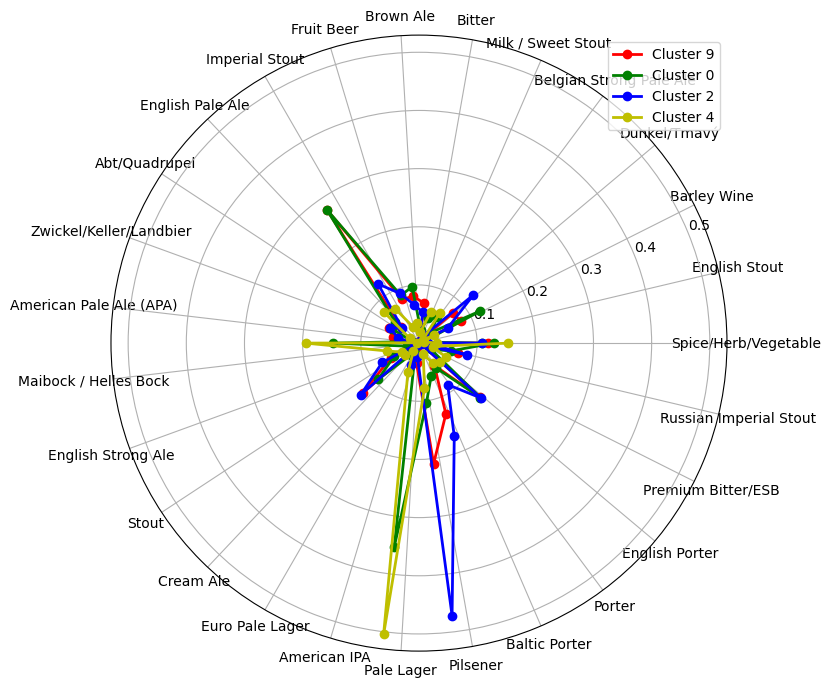

In [154]:
labels = df_radar_shuffled.columns.drop('Cluster').tolist()

# Set the angles for the labels
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)

# Create the figure and the subplot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)

# Set the labels for the categories
ax.set_thetagrids(angles * 180/np.pi, labels)

# Plot the data for each cluster
ax.plot(label_loc, data1, label='Cluster 9', color='r', linewidth=2, marker='o')
ax.plot(label_loc, data2, label='Cluster 0', color='g', linewidth=2, marker='o')
ax.plot(label_loc, data3, label='Cluster 2', color='b', linewidth=2, marker='o')
ax.plot(label_loc, data4, label='Cluster 4', color='y', linewidth=2, marker='o')

# Add a legend and show the plot
plt.legend()
plt.show()